# Vancouver Theft Incidents Analysis

## Project Overview

This project aims to analyze theft incident patterns in Vancouver, identify high-risk areas and time periods through data mining and machine learning methods, and provide data-driven insights for community safety strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set_palette('husl')
pd.set_option('display.max_columns', None)

## 1. Data Loading and Initial Exploration

First, load the data and perform initial exploration to understand its basic structure and characteristics.

In [2]:
# Load data
df = pd.read_csv('crime.csv')

#Filter theft-related incidents
theft_df = df[df['TYPE'].str.contains('Theft', case=False, na=False)]

#Display basic information
print("Dataset Overview:")
print(f"Total theft incidents: {len(theft_df)}")
print("\nSample of the data:")
display(theft_df.head())

#Check data quality
print("\nData Types:")
print(theft_df.dtypes)
print("\nMissing Values:")
print(theft_df.isnull().sum())

Dataset Overview:
Total theft incidents: 289015

Sample of the data:


TYPE  YEAR  MONTH  DAY  HOUR  MINUTE     HUNDRED_BLOCK  \
0  Other Theft  2003      5   12  16.0    15.0  9XX TERMINAL AVE   
1  Other Theft  2003      5    7  15.0    20.0  9XX TERMINAL AVE   
2  Other Theft  2003      4   23  16.0    40.0  9XX TERMINAL AVE   
3  Other Theft  2003      4   20  11.0    15.0  9XX TERMINAL AVE   
4  Other Theft  2003      4   12  17.0    45.0  9XX TERMINAL AVE   

  NEIGHBOURHOOD         X           Y   Latitude   Longitude  
0    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
1    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
2    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
3    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
4    Strathcona  493906.5  5457452.47  49.269802 -123.083763


Data Types:
TYPE              object
YEAR               int64
MONTH              int64
DAY                int64
HOUR             float64
MINUTE           float64
HUNDRED_BLOCK     object
NEIGHBOURHOOD     object
X                float64
Y                float64
Latitude         float64
Longitude        float64
dtype: object

Missing Values:
TYPE                0
YEAR                0
MONTH               0
DAY                 0
HOUR                0
MINUTE              0
HUNDRED_BLOCK       6
NEIGHBOURHOOD    1989
X                   0
Y                   0
Latitude            0
Longitude           0
dtype: int64


## 2. Data Preprocessing

### 2.1 Data Cleaning & Validation

Handle missing values and outliers to ensure data quality.

In [3]:
theft_df = df[df['TYPE'].str.contains('Theft', case=False, na=False)].copy()

missing_values = theft_df.isnull().sum()
print("Missing Values Statistics:")
print(missing_values[missing_values > 0])

# Handle missing values
theft_df['NEIGHBOURHOOD'].fillna('Unknown', inplace=True)
theft_df['HUNDRED_BLOCK'].fillna('Unknown', inplace=True)

# Check duplicates
duplicates = theft_df.duplicated().sum()
print(f"\nNumber of duplicate records: {duplicates}")
theft_df.drop_duplicates(inplace=True)

Missing Values Statistics:
HUNDRED_BLOCK       6
NEIGHBOURHOOD    1989
dtype: int64

Number of duplicate records: 1


### 2.2 Feature Engineering

Create new features to enhance analysis capabilities.

In [9]:
from datetime import datetime
# Create time-related features
theft_df.loc[:, 'TimeOfDay'] = pd.cut(theft_df['HOUR'],
                                      bins=[0, 6, 12, 18, 24],
                                      labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)'])

theft_df.loc[:, 'Season'] = pd.cut(theft_df['MONTH'],
                                   bins=[0, 3, 6, 9, 12],
                                   labels=['Winter', 'Spring', 'Summer', 'Fall'])

theft_df.loc[:, 'IsWeekend'] = theft_df.apply(
    lambda row: datetime(
        year=row['YEAR'],
        month=row['MONTH'],
        day=row['DAY']
    ).weekday() >= 5 if pd.notnull(row['DAY']) else np.nan,
    axis=1
)

# Create geographical features
center_lat = theft_df['Latitude'].mean()
center_lon = theft_df['Longitude'].mean()
theft_df.loc[:, 'DistanceFromCenter'] = np.sqrt(
    (theft_df['Latitude'] - center_lat)**2 +
    (theft_df['Longitude'] - center_lon)**2
)

# Display statistics of new features
print(r"New Features Statistics:")
print(r"Time Period Distribution:")
print(theft_df['TimeOfDay'].value_counts())
print(r"Seasonal Distribution:")
print(theft_df['Season'].value_counts())

New Features Statistics:
Time Period Distribution:
TimeOfDay
Afternoon (12-18)    104340
Evening (18-24)       91397
Morning (6-12)        56398
Night (0-6)           21179
Name: count, dtype: int64
Seasonal Distribution:
Season
Summer    75614
Spring    75354
Winter    70385
Fall      67661
Name: count, dtype: int64


### 2.3 Data Integration with Neighborhood Info

Integrate neighborhood-level statistics to provide multi-dimensional data support for subsequent analysis.

 Neighborhood Crime Statistics:


Total Incidents  Average Time  Time Std  \
NEIGHBOURHOOD                                                        
Arbutus Ridge                         2847        14.897     6.860   
Central Business District            78169        14.278     5.920   
Dunbar-Southlands                     4009        15.004     7.212   
Fairview                             20634        14.618     6.034   
Grandview-Woodland                   14364        14.470     6.713   

                           Weekend Incident Ratio  \
NEIGHBOURHOOD                                       
Arbutus Ridge                               0.280   
Central Business District                   0.311   
Dunbar-Southlands                           0.290   
Fairview                                    0.286   
Grandview-Woodland                          0.288   

                           Average Distance from Center  
NEIGHBOURHOOD                                            
Arbutus Ridge                                     0.057  
Central Business District                         0.020  
Dunbar-Southlands                                 0.080  
Fairview                                          0.022  
Grandview-Woodland                                0.042

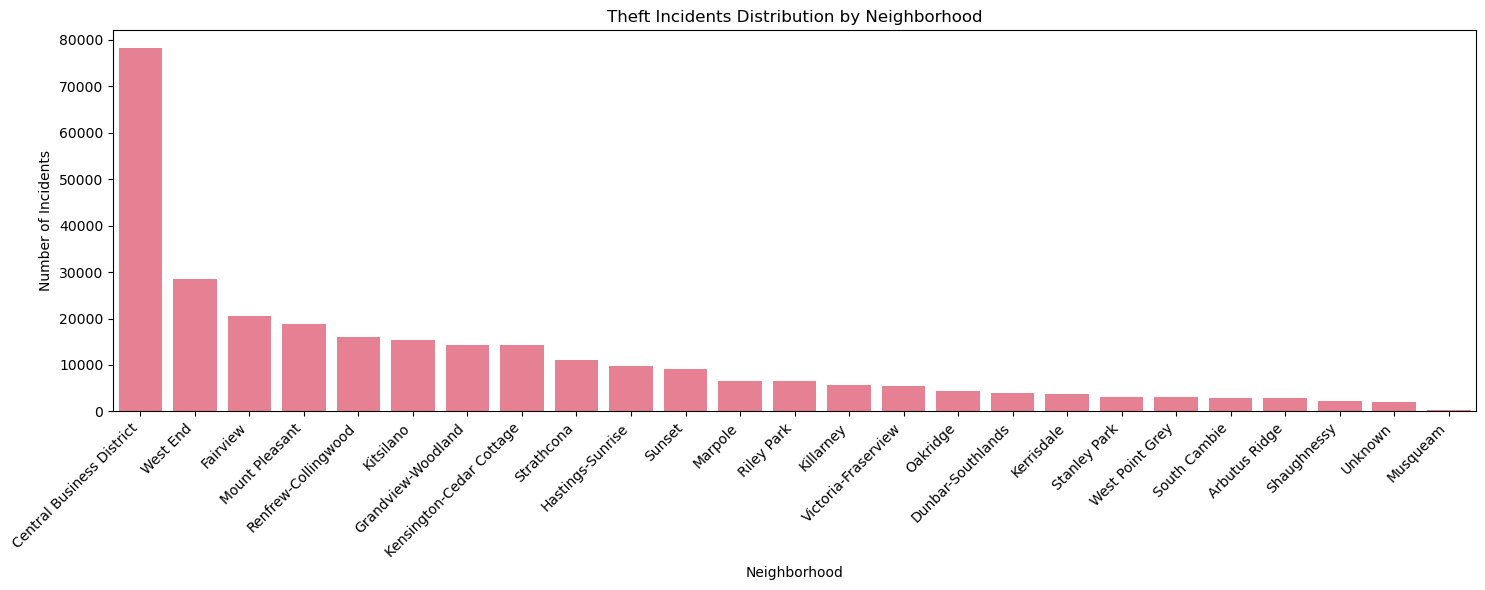

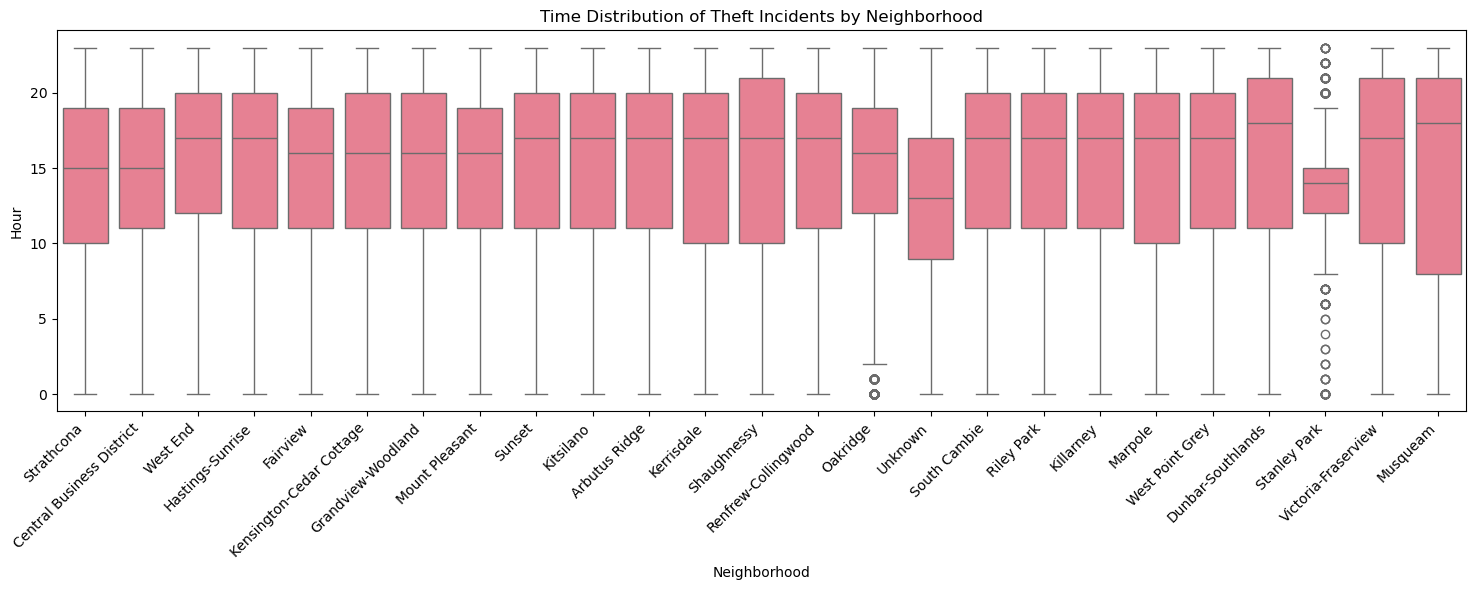

In [5]:
# Calculate neighborhood-level statistics
neighborhood_stats = theft_df.groupby('NEIGHBOURHOOD').agg({
    'TYPE': 'count',                   # Total incidents
    'HOUR': ['mean', 'std'],           # Average time and std
    'IsWeekend': 'mean',               # Weekend incident ratio
    'DistanceFromCenter': 'mean'       # Average distance from center
}).round(3)

# Rename columns
neighborhood_stats.columns = ['Total Incidents', 'Average Time', 'Time Std', 'Weekend Incident Ratio', 'Average Distance from Center']

# Display neighborhood statistics
print(" Neighborhood Crime Statistics:")
display(neighborhood_stats.head())

# Visualize neighborhood incident distribution
plt.figure(figsize=(15, 6))
sns.barplot(x=neighborhood_stats.index, 
           y=neighborhood_stats['Total Incidents'],
           order=neighborhood_stats.sort_values('Total Incidents', ascending=False).index)
plt.title('Theft Incidents Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze neighborhood time patterns
plt.figure(figsize=(15, 6))
sns.boxplot(x='NEIGHBOURHOOD', y='HOUR', data=theft_df)
plt.title('Time Distribution of Theft Incidents by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Hour')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Spatiotemporal Analysis

### 3.1 Theft Distribution by Neighborhood

Analyze the distribution of theft incidents across different neighborhoods.

In [6]:
import os

# Create geographical heatmap with adjusted parameters
vancouver_center = [theft_df['Latitude'].mean(), theft_df['Longitude'].mean()]
m = folium.Map(location=vancouver_center, zoom_start=13)

# Add heatmap layer with refined parameters
heat_data = [[row['Latitude'], row['Longitude']] for index, row in theft_df.iterrows()]
HeatMap(
    heat_data,
    radius=8,          # 减小热点半径
    blur=5,            # 减小模糊程度
    max_zoom=15,       # 增加最大缩放级别
    min_opacity=0.3,   # 降低最小不透明度
    gradient={         # 自定义渐变色
        0.2: '#fee0d2',
        0.4: '#fc9272',
        0.6: '#de2d26',
        0.8: '#a50f15'
    }
).add_to(m)

# Add neighborhood boundaries for better context
geo_json = 'vancouver_neighborhoods.geojson'  # 如果有边界数据的话
if os.path.exists(geo_json):
    folium.GeoJson(
        geo_json,
        style_function=lambda x: {
            'fillColor': 'transparent',
            'color': 'black',
            'weight': 1
        }
    ).add_to(m)

# Add a legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 150px; height: 90px; 
     border:2px solid grey; z-index:9999; background-color:white;
     opacity:0.8;
     font-size:12px;
     padding: 10px">
     <p><strong>Crime Density</strong></p>
     <p style="color:#fee0d2">&#9632; Low</p>
     <p style="color:#de2d26">&#9632; Medium</p>
     <p style="color:#a50f15">&#9632; High</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add scale bar
folium.plugins.MeasureControl().add_to(m)

# Display map
m

### 3.1.1 Use Random Forest to Predict Theft Incidents

# The model is used to predict the neighborhood of theft incidents, parameters are tuned to improve the accuracy.

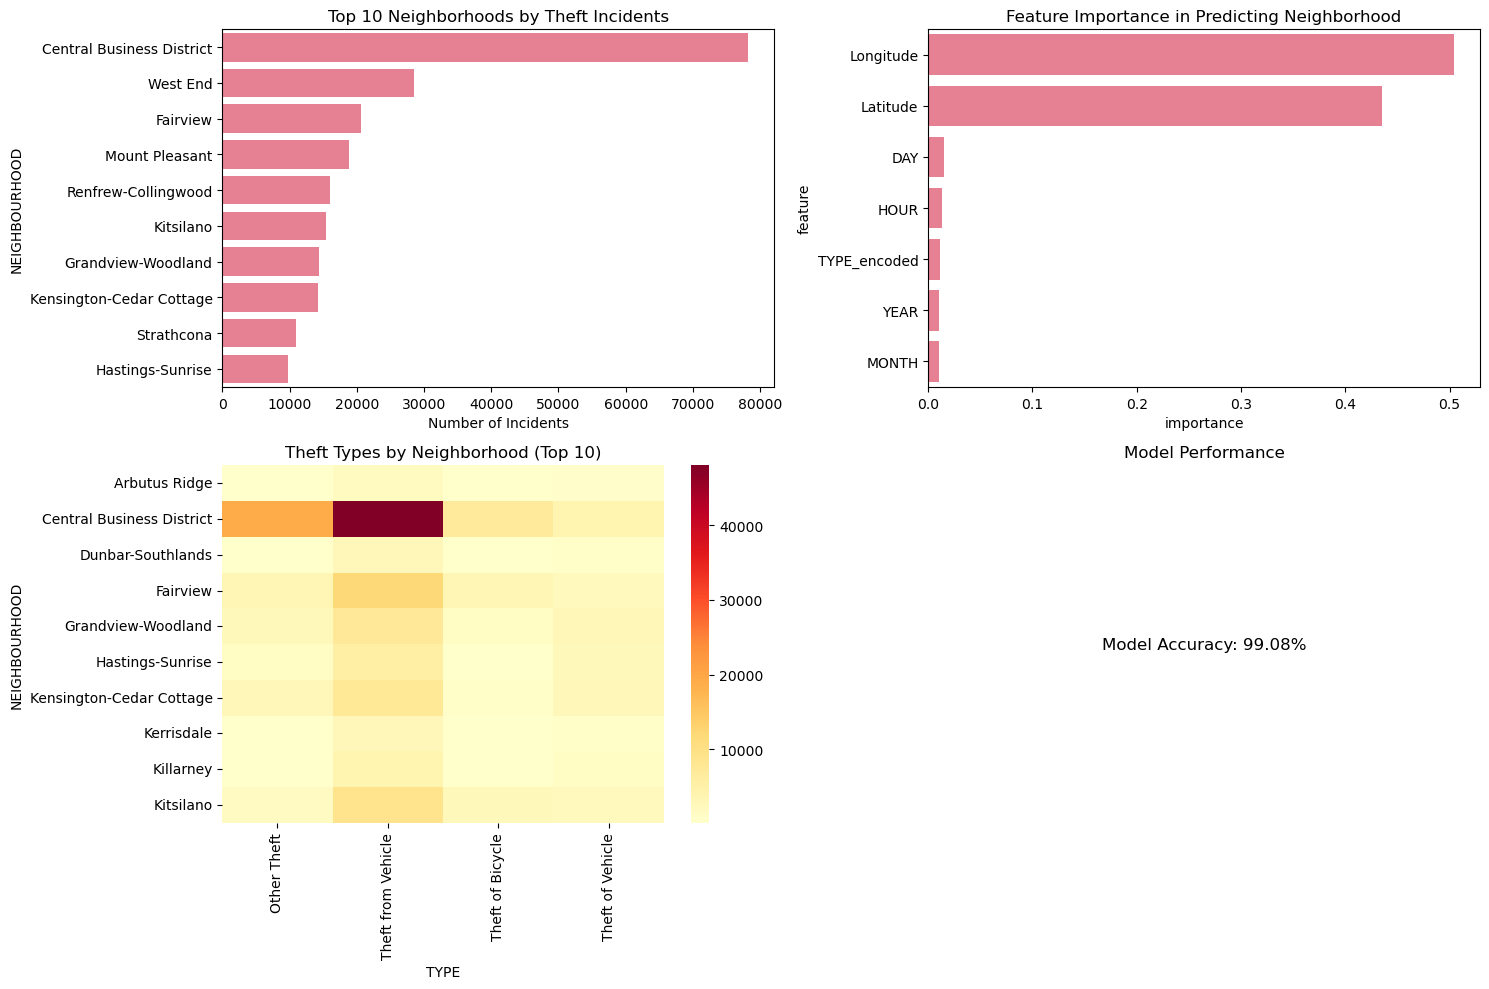


Classification Report:
                           precision    recall  f1-score   support

            Arbutus Ridge       0.96      0.96      0.96       575
Central Business District       1.00      0.99      1.00     15732
        Dunbar-Southlands       0.97      0.97      0.97       754
                 Fairview       0.99      1.00      0.99      4180
       Grandview-Woodland       1.00      1.00      1.00      2894
         Hastings-Sunrise       0.99      1.00      1.00      1967
 Kensington-Cedar Cottage       0.98      1.00      0.99      2806
               Kerrisdale       0.95      0.98      0.96       756
                Killarney       0.98      0.98      0.98      1125
                Kitsilano       0.99      1.00      0.99      3082
                  Marpole       0.99      0.99      0.99      1363
           Mount Pleasant       0.99      0.99      0.99      3772
                 Musqueam       1.00      0.74      0.85        61
                 Oakridge       0.99 

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe to avoid SettingWithCopyWarning
theft_df_ml = theft_df.copy()

# Clean data - remove rows with NaN values in NEIGHBOURHOOD
theft_df_ml = theft_df_ml.dropna(subset=['NEIGHBOURHOOD'])

# Prepare features
le_neighborhood = LabelEncoder()
le_type = LabelEncoder()

# Properly encode categorical variables
theft_df_ml.loc[:, 'NEIGHBOURHOOD_encoded'] = le_neighborhood.fit_transform(theft_df_ml['NEIGHBOURHOOD'])
theft_df_ml.loc[:, 'TYPE_encoded'] = le_type.fit_transform(theft_df_ml['TYPE'])

# Create feature matrix
features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'TYPE_encoded', 'Latitude', 'Longitude']
X = theft_df_ml[features]
y = theft_df_ml['NEIGHBOURHOOD_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualization
plt.figure(figsize=(15, 10))

# 1. Theft incidents by neighborhood
plt.subplot(2, 2, 1)
neighborhood_counts = theft_df_ml['NEIGHBOURHOOD'].value_counts()
sns.barplot(x=neighborhood_counts.values[:10], y=neighborhood_counts.index[:10])
plt.title('Top 10 Neighborhoods by Theft Incidents')
plt.xlabel('Number of Incidents')

# 2. Feature importance
plt.subplot(2, 2, 2)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Neighborhood')

# 3. Neighborhood-Type distribution heatmap
plt.subplot(2, 2, 3)
neighborhood_type_pivot = pd.crosstab(theft_df_ml['NEIGHBOURHOOD'], theft_df_ml['TYPE'])
sns.heatmap(neighborhood_type_pivot.head(10), cmap='YlOrRd')
plt.title('Theft Types by Neighborhood (Top 10)')

# 4. Model accuracy
plt.subplot(2, 2, 4)
accuracy = rf_model.score(X_test, y_test)
plt.text(0.5, 0.5, f'Model Accuracy: {accuracy:.2%}', 
         horizontalalignment='center', verticalalignment='center', fontsize=12)
plt.axis('off')
plt.title('Model Performance')

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
# Get unique neighborhoods from the encoder
unique_neighborhoods = le_neighborhood.classes_
print(classification_report(y_test, y_pred, 
                          target_names=unique_neighborhoods,
                          zero_division=0))

# Calculate risk scores
# The risk score is used to identify the neighborhoods with high theft incidents, 
# the score is calculated by the incident count and the average confidence of the predictions.
risk_scores = pd.DataFrame({
    'Neighborhood': unique_neighborhoods,
    'Incident_Count': theft_df_ml['NEIGHBOURHOOD'].value_counts().reindex(unique_neighborhoods).fillna(0)
})

# Add prediction probabilities
test_probs = rf_model.predict_proba(X_test)
risk_scores['Average_Confidence'] = np.mean(test_probs, axis=0)

# Calculate normalized risk score
# This is the normalized incident count, the range is [0, 1], can be used to identify the neighborhoods with high theft incidents.
risk_scores['Incident_Count_Normalized'] = (risk_scores['Incident_Count'] - risk_scores['Incident_Count'].min()) / \
                                         (risk_scores['Incident_Count'].max() - risk_scores['Incident_Count'].min())
risk_scores['Risk_Score'] = (risk_scores['Incident_Count_Normalized'] * 0.7 + 
                            risk_scores['Average_Confidence'] * 0.3)

# Display top risk scores
print("\nNeighborhood Risk Analysis (Top 10):")
print(risk_scores.sort_values('Risk_Score', ascending=False)
      .head(10)
      .to_string(float_format=lambda x: '{:.3f}'.format(x)))

### 3.2 Peak Time Analysis

Analyze temporal patterns of theft incidents to identify peak times.

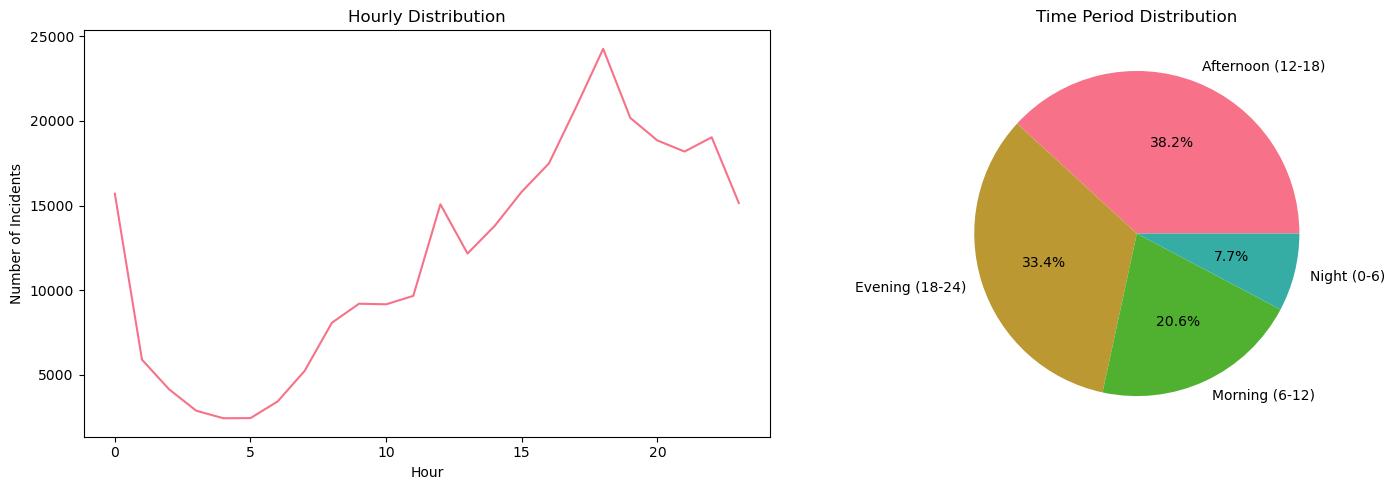

In [7]:
# Analyze time distribution
plt.figure(figsize=(15, 5))

# Hourly distribution
plt.subplot(1, 2, 1)
hourly_counts = theft_df['HOUR'].value_counts().sort_index()
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title('Hourly Distribution')
plt.xlabel('Hour')
plt.ylabel('Number of Incidents')

# Time period distribution
plt.subplot(1, 2, 2)
time_period_counts = theft_df['TimeOfDay'].value_counts()
plt.pie(time_period_counts, labels=time_period_counts.index, autopct='%1.1f%%')
plt.title('Time Period Distribution')

plt.tight_layout()
plt.show()

### 3.2.1 Predict Theft Incidents with Random Forest by Location and Type
# 主要参数有：n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features

Model Performance Metrics:
Accuracy: 0.745

Cross Validation Scores:
Mean CV Score: 0.740 (+/- 0.004)

Detailed Classification Report:
                    precision    recall  f1-score   support

       Other Theft       0.89      0.86      0.88     10433
Theft from Vehicle       0.72      0.97      0.82     34540
  Theft of Bicycle       0.63      0.07      0.13      5146
  Theft of Vehicle       0.59      0.00      0.01      7684

          accuracy                           0.74     57803
         macro avg       0.70      0.48      0.46     57803
      weighted avg       0.72      0.74      0.66     57803


Feature Importance:
Latitude: 0.480
Longitude: 0.455
NEIGHBOURHOOD_encoded: 0.064


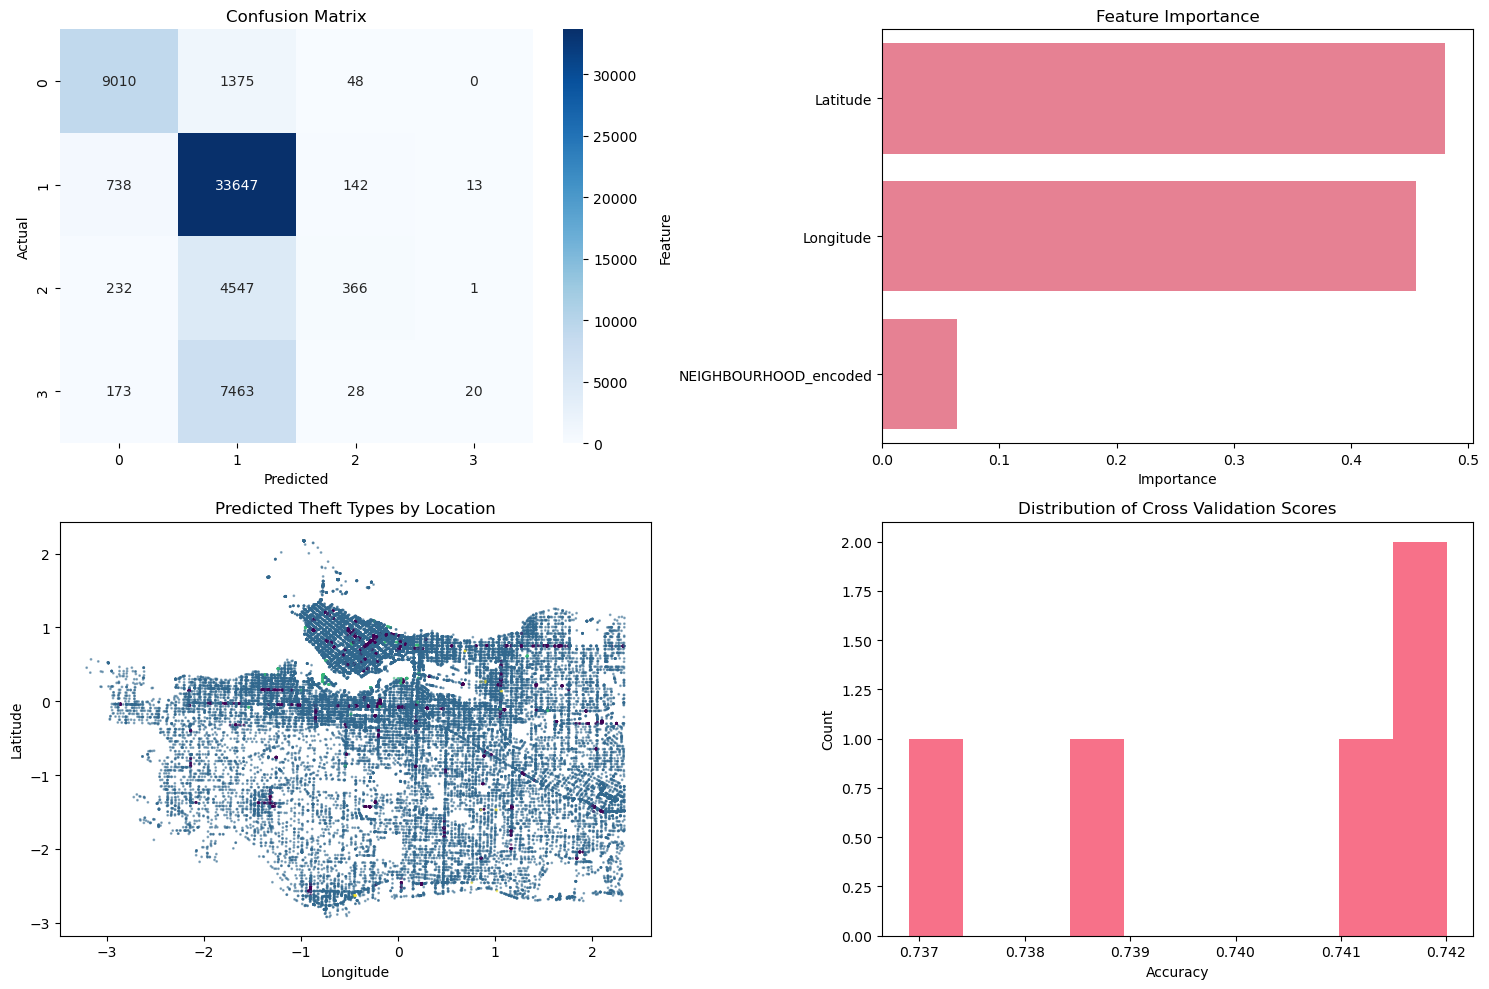


Neighborhood Analysis:

Top 10 Neighborhoods by Risk Score:
                           Sample_Size  CV_Score  Incident_Rate  Risk_Score
Central Business District        78170  0.810643       0.270470    0.486540
NaN                               1989  0.909503       0.006882    0.367931
West End                         28582  0.758660       0.098895    0.362801
Stanley Park                      3169  0.888274       0.010965    0.361889
Fairview                         20634  0.690316       0.071394    0.318963
Renfrew-Collingwood              15969  0.709811       0.055253    0.317076
Kerrisdale                        3796  0.746051       0.013134    0.306301
Musqueam                           265  0.762264       0.000917    0.305456
Strathcona                       11002  0.697963       0.038067    0.302025
South Cambie                      2944  0.726551       0.010186    0.296732


In [21]:
# Location and Type Based Analysis with Prediction Scoring
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns

# Prepare the data
theft_df_ml = theft_df.copy()

# Remove TYPE from features to avoid data leakage
features = ['Latitude', 'Longitude', 'NEIGHBOURHOOD']
target = 'TYPE'

# Encode categorical variables
le_neighborhood = LabelEncoder()
le_type = LabelEncoder()

# Create feature matrix
X = pd.DataFrame()
X['Latitude'] = theft_df_ml['Latitude']
X['Longitude'] = theft_df_ml['Longitude']
X['NEIGHBOURHOOD_encoded'] = le_neighborhood.fit_transform(theft_df_ml['NEIGHBOURHOOD'])

# Create target variable
y = le_type.fit_transform(theft_df_ml[target])

# Scale numerical features
scaler = StandardScaler()
X[['Latitude', 'Longitude']] = scaler.fit_transform(X[['Latitude', 'Longitude']])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model with more reasonable parameters
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    random_state=42
)

rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate scores
accuracy = accuracy_score(y_test, y_pred)
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"\nCross Validation Scores:")
print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Print classification report
print("\nDetailed Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=le_type.classes_,
    zero_division=0
))

# Feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")

# Visualize results
plt.figure(figsize=(15, 10))

# Plot 1: Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 2: Feature Importance
plt.subplot(2, 2, 2)
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')

# Plot 3: Spatial Distribution
plt.subplot(2, 2, 3)
plt.scatter(X_test['Longitude'], X_test['Latitude'], 
           c=y_pred, alpha=0.5, s=1)
plt.title('Predicted Theft Types by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot 4: Cross Validation Distribution
plt.subplot(2, 2, 4)
plt.hist(cv_scores, bins=10)
plt.title('Distribution of Cross Validation Scores')
plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Analyze neighborhood-specific performance
neighborhood_performance = {}
for name, encoded_val in zip(le_neighborhood.classes_, range(len(le_neighborhood.classes_))):
    # Get data for this neighborhood
    mask = X['NEIGHBOURHOOD_encoded'] == encoded_val
    if mask.sum() > 100:  # Only analyze neighborhoods with sufficient data
        X_hood = X[mask]
        y_hood = y[mask]
        
        # Calculate metrics
        cv_score = cross_val_score(
            RandomForestClassifier(random_state=42), 
            X_hood, y_hood, cv=min(5, mask.sum() // 20)
        ).mean()
        
        neighborhood_performance[name] = {
            'Sample_Size': mask.sum(),
            'CV_Score': cv_score,
            'Incident_Rate': mask.sum() / len(X)
        }

# Convert to DataFrame
neighborhood_df = pd.DataFrame.from_dict(neighborhood_performance, orient='index')
neighborhood_df['Risk_Score'] = (
    0.4 * neighborhood_df['CV_Score'] + 
    0.6 * neighborhood_df['Incident_Rate']
)

print("\nNeighborhood Analysis:")
print("\nTop 10 Neighborhoods by Risk Score:")
print(neighborhood_df.sort_values('Risk_Score', ascending=False).head(10))

### 3.2.2 Predict Theft Incidents with Random Forest by Time and Type
# 通过时间、地点和类型来预测盗窃事件，主要参数有：n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
# 时间特征有：Hour, DayOfWeek, Month, Season, IsWeekend, TimeOfDay
# 地点特征有：Latitude, Longitude, NEIGHBOURHOOD_encoded
# NEIGHBOURHOOD_encoded是经过编码的neighborhood，用于分类。

     DateTime  DayOfWeek  IsWeekend WeekdayName
0  2003-05-12          0          0      Monday
1  2003-05-07          2          0   Wednesday
2  2003-04-23          2          0   Wednesday
3  2003-04-20          6          1      Sunday
4  2003-04-12          5          1    Saturday
5  2003-03-26          2          0   Wednesday
8  2003-02-16          6          1      Sunday
10 2003-01-31          4          0      Friday
17 2003-01-25          5          1    Saturday
19 2003-01-09          3          0    Thursday
Model Performance Metrics:
Accuracy: 0.710

Cross Validation Scores:
Mean CV Score: 0.703 (+/- 0.002)

Detailed Classification Report:
                    precision    recall  f1-score   support

       Other Theft       0.88      0.67      0.76     10433
Theft from Vehicle       0.68      0.98      0.80     34540
  Theft of Bicycle       0.76      0.02      0.04      5146
  Theft of Vehicle       0.00      0.00      0.00      7684

          accuracy                 

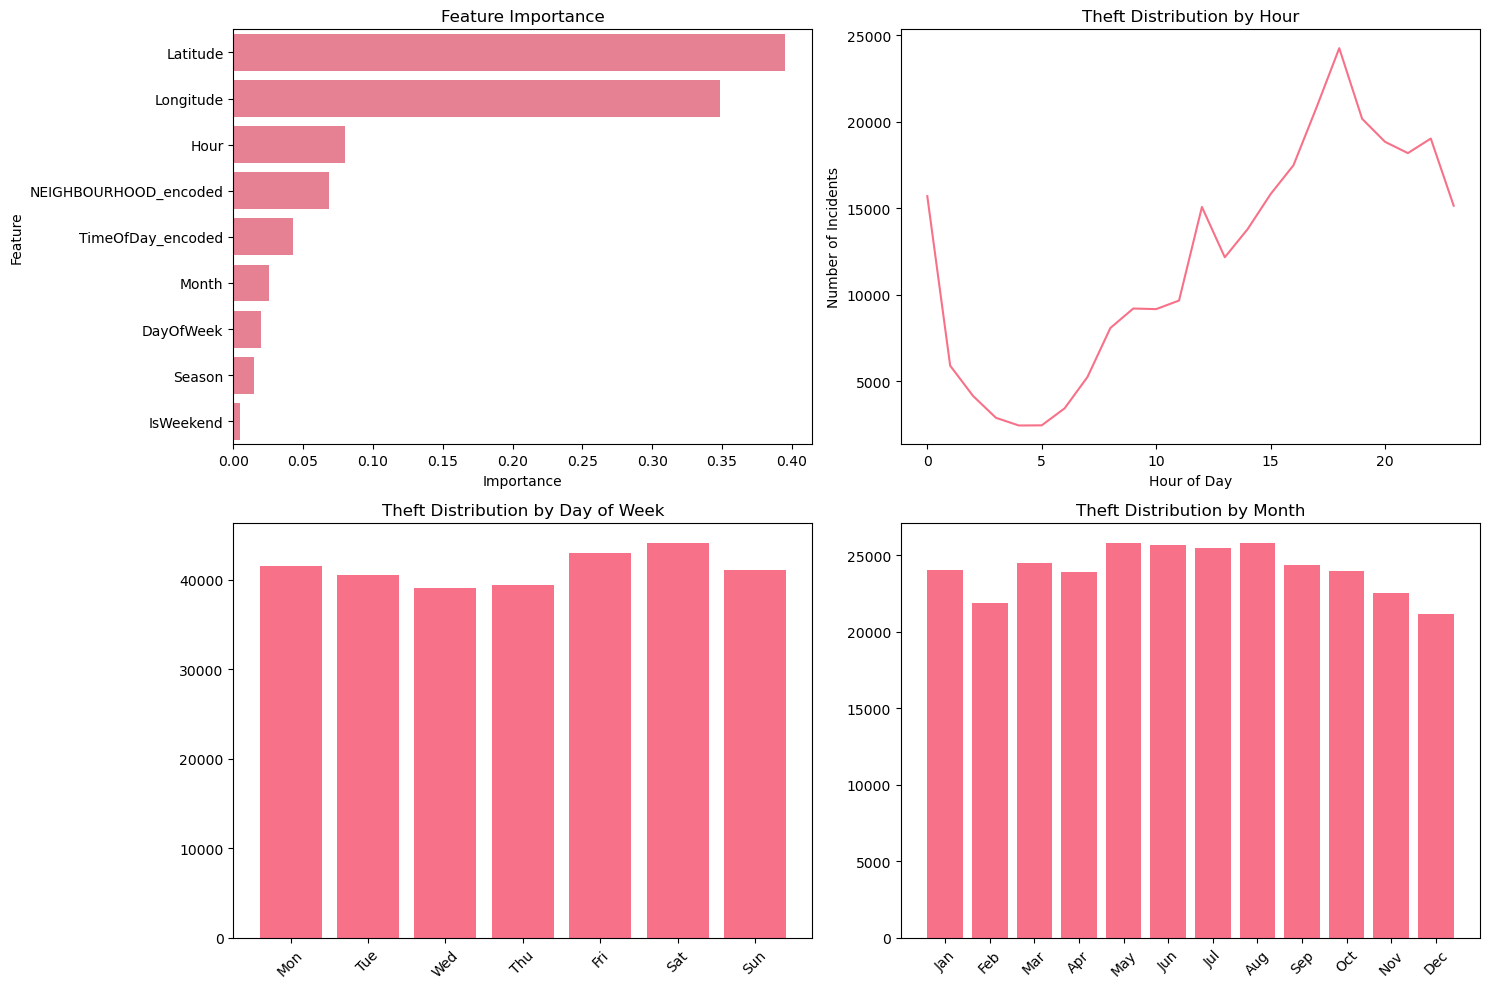


Time-based Patterns:

Busiest Times of Day:
TimeOfDay
Afternoon    104341
Evening       91397
Morning       56398
Night         36879
Name: TYPE, dtype: int64

Busiest Days of Week:
Sat: 44,143 incidents
Fri: 43,011 incidents
Mon: 41,572 incidents
Sun: 41,134 incidents
Tue: 40,572 incidents
Thu: 39,448 incidents
Wed: 39,135 incidents

Busiest Months:
May: 25,806 incidents
Aug: 25,781 incidents
Jun: 25,651 incidents
Jul: 25,487 incidents
Mar: 24,473 incidents
Sep: 24,346 incidents
Jan: 24,054 incidents
Oct: 23,968 incidents
Apr: 23,897 incidents
Nov: 22,526 incidents
Feb: 21,858 incidents
Dec: 21,168 incidents


In [25]:
# Location and Time Based Analysis with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns

# Prepare the data
theft_df_ml = theft_df.copy()

# Create datetime and time-based features
theft_df_ml['DateTime'] = pd.to_datetime(theft_df_ml[['YEAR', 'MONTH', 'DAY']])
theft_df_ml['Hour'] = theft_df_ml['HOUR']
theft_df_ml['DayOfWeek'] = theft_df_ml['DateTime'].dt.dayofweek
theft_df_ml['Month'] = theft_df_ml['DateTime'].dt.month
theft_df_ml['Season'] = theft_df_ml['DateTime'].dt.month % 12 // 3
theft_df_ml['IsWeekend'] = theft_df_ml['DayOfWeek'].isin([5, 6]).astype(int)
theft_df_ml['TimeOfDay'] = pd.cut(theft_df_ml['Hour'], 
                                 bins=[-1, 6, 12, 18, 24], 
                                 labels=['Night', 'Morning', 'Afternoon', 'Evening'])
# Test week day and weekend
test_df = theft_df_ml[['DateTime', 'DayOfWeek', 'IsWeekend']].head(10)
test_df['WeekdayName'] = test_df['DateTime'].dt.day_name()
print(test_df)

# Encode categorical variables
le_neighborhood = LabelEncoder()
le_type = LabelEncoder()
le_time_of_day = LabelEncoder()

# Create feature matrix
X = pd.DataFrame()
# Location features
X['Latitude'] = theft_df_ml['Latitude']
X['Longitude'] = theft_df_ml['Longitude']
X['NEIGHBOURHOOD_encoded'] = le_neighborhood.fit_transform(theft_df_ml['NEIGHBOURHOOD'])

# Time features
X['Hour'] = theft_df_ml['Hour']
X['DayOfWeek'] = theft_df_ml['DayOfWeek']
X['Month'] = theft_df_ml['Month']
X['Season'] = theft_df_ml['Season']
X['IsWeekend'] = theft_df_ml['IsWeekend']
X['TimeOfDay_encoded'] = le_time_of_day.fit_transform(theft_df_ml['TimeOfDay'])

# Create target variable
y = le_type.fit_transform(theft_df_ml['TYPE'])

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Latitude', 'Longitude', 'Hour']
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    random_state=42
)

rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate scores
accuracy = accuracy_score(y_test, y_pred)
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"\nCross Validation Scores:")
print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Print classification report
print("\nDetailed Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=le_type.classes_,
    zero_division=0
))

# Feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")

# Visualize results
plt.figure(figsize=(15, 10))

# Plot 1: Feature Importance
plt.subplot(2, 2, 1)
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')

# Plot 2: Time of Day Distribution
plt.subplot(2, 2, 2)
theft_by_hour = theft_df_ml.groupby('Hour')['TYPE'].count()
plt.plot(theft_by_hour.index, theft_by_hour.values)
plt.title('Theft Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Incidents')

# Plot 3: Day of Week Distribution
plt.subplot(2, 2, 3)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
theft_by_day = theft_df_ml.groupby('DayOfWeek')['TYPE'].count()
plt.bar(days, theft_by_day.values)
plt.title('Theft Distribution by Day of Week')
plt.xticks(rotation=45)

# Plot 4: Monthly Distribution
plt.subplot(2, 2, 4)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
theft_by_month = theft_df_ml.groupby('Month')['TYPE'].count()
plt.bar(months, theft_by_month.values)
plt.title('Theft Distribution by Month')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Time-based analysis
print("\nTime-based Patterns:")
print("\nBusiest Times of Day:")
print(theft_df_ml.groupby('TimeOfDay')['TYPE'].count().sort_values(ascending=False))

print("\nBusiest Days of Week:")
day_counts = theft_df_ml.groupby('DayOfWeek')['TYPE'].count().sort_values(ascending=False)
for day_num, count in day_counts.items():
    print(f"{days[day_num]}: {count:,} incidents")

print("\nBusiest Months:")
month_counts = theft_df_ml.groupby('Month')['TYPE'].count().sort_values(ascending=False)
for month_num, count in month_counts.items():
    print(f"{months[month_num-1]}: {count:,} incidents")